<a href="https://colab.research.google.com/github/manashpratim/CIFAR100-Experiments/blob/main/CIFAR100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**CIFAR 100 Experiments**

### **Importing libraries**

In [1]:
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam,Adamax,Nadam,RMSprop
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from mlxtend.plotting import plot_confusion_matrix
from keras.utils import np_utils 
from keras.utils.vis_utils import plot_model

In [2]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

169009152/169001437 [==============================] - 2s 0us/step


In [3]:
y_train_cat = np_utils.to_categorical(y_train, 100) 
y_test_cat = np_utils.to_categorical(y_test, 100)

In [4]:
#Rescaling and normalizing the data
x_train1 = x_train/255.
x_test1 = x_test/255.

x_train1[:,:,:,0] = (x_train1[:,:,:,0]-0.507362034824345)/0.26748815488001604
x_train1[:,:,:,1] = (x_train1[:,:,:,1]-0.4866895632914611)/0.2565930997269337
x_train1[:,:,:,2] = (x_train1[:,:,:,2]-0.4410885713465068)/0.2763085095510783

x_test1[:,:,:,0] = (x_test1[:,:,:,0]-0.507362034824345)/0.26748815488001604
x_test1[:,:,:,1] = (x_test1[:,:,:,1]-0.4866895632914611)/0.2565930997269337
x_test1[:,:,:,2] = (x_test1[:,:,:,2]-0.4410885713465068)/0.2763085095510783

### **Linear Regression**

In [7]:
def make_model1(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    x = Flatten()(inputs)
    outputs = Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)

In [8]:
model1 = make_model1((32,32,3), 100)

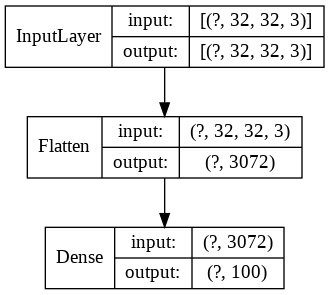

In [9]:
plot_model(model1, to_file='residual.png', show_shapes=True, show_layer_names=False)

In [10]:
model1.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               307300    
Total params: 307,300
Trainable params: 307,300
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epochs = 50
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("save_model1_at_{epoch}.h5"),
    tf. keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, mode='auto')
]

model1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),#,decay=1e-6),
    loss='categorical_crossentropy',
    metrics=["accuracy"]
)

history = model1.fit(
    x_train1,y_train_cat, epochs=epochs, callbacks=callbacks,batch_size=64, validation_data=(x_test1,y_test_cat),
)

## **CNN**

In [11]:
model2=tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(128,(3,3),activation='relu',input_shape=(32,32,3),padding='same'),
    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(256,(3,3),activation='relu'),
    tf.keras.layers.Conv2D(256,(3,3),activation='relu'),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(512,(3,3),activation='relu'),
    tf.keras.layers.Conv2D(512,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.GlobalAveragePooling2D(),
       
    tf.keras.layers.Dense(1024,activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100,activation='softmax')
])

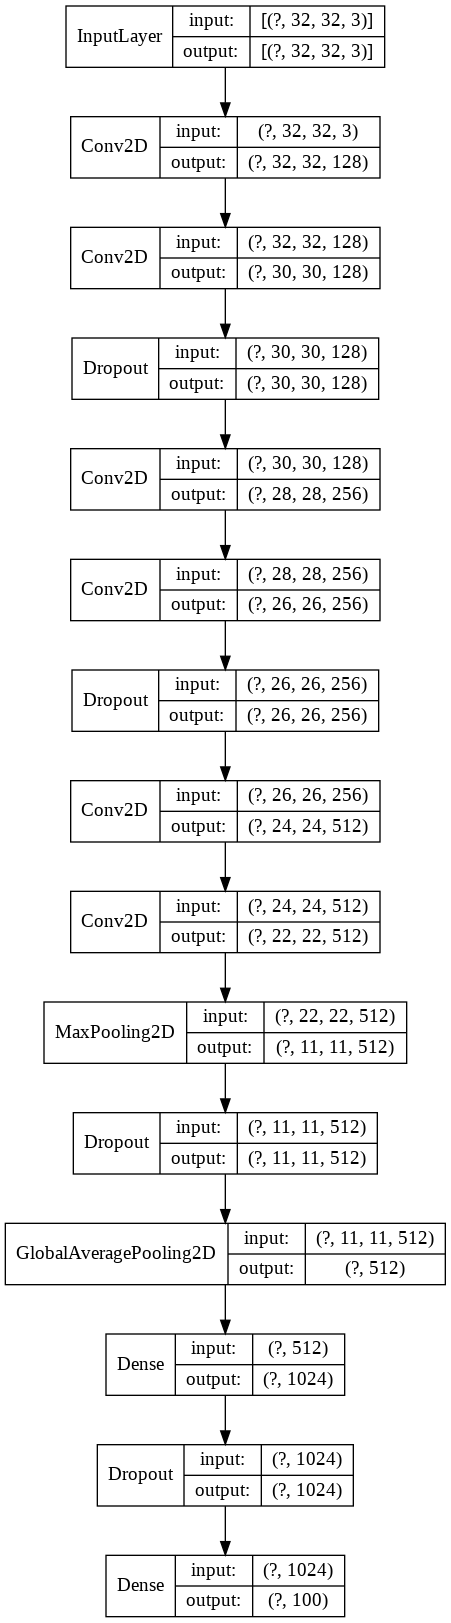

In [12]:
plot_model(model2, to_file='residual.png', show_shapes=True, show_layer_names=False)

In [13]:
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 128)       3584      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 128)       147584    
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 256)       295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 256)       590080    
_________________________________________________________________
dropout_1 (Dropout)          (None, 26, 26, 256)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 512)       1

In [ ]:
epochs = 50
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("save_model1_at_{epoch}.h5"),
    tf. keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, mode='auto')
]

model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),#,decay=1e-6),
    loss='categorical_crossentropy',
    metrics=["accuracy"]
)

history = model2.fit(
    x_train1,y_train_cat, epochs=epochs, callbacks=callbacks,batch_size=64, validation_data=(x_test1,y_test_cat),
)

## **CNN with residual skip connectons**

In [14]:
def make_model3(input_shape, num_classes):
    
    inputs = tf.keras.Input(shape=input_shape)
    
    x =  tf.keras.layers.Conv2D(128,  kernel_size = (3, 3),use_bias=False)(inputs)
    x =  tf.keras.layers.BatchNormalization()(x)
    x =  tf.keras.activations.relu(x)
    x1 = tf.keras.layers.Conv2D(128,(3,3),use_bias=False,padding='same')(x)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.activations.relu(x)
    x1 = tf.keras.layers.Add()([x, x1])
    x1 = tf.keras.activations.relu(x1)
    x1 = tf.keras.layers.Dropout(0.2)(x1)

    x2 = tf.keras.layers.Conv2D(256,(3,3),use_bias=False,padding='same')(x1)
    x2 = tf.keras.layers.BatchNormalization()(x2)
    x2 = tf.keras.activations.relu(x2)
    x2 = tf.keras.layers.Conv2D(256,(3,3),use_bias=False,padding='same')(x2)
    x2 = tf.keras.layers.BatchNormalization()(x2)
    x2 = tf.keras.activations.relu(x2)
    x =  tf.keras.layers.Conv2D(256,(1,1),use_bias=False,padding='same')(x)
    x2 = tf.keras.layers.Add()([x, x2])
    x2 = tf.keras.activations.relu(x2)
    x2 = tf.keras.layers.Dropout(0.3)(x2)

    x3 = tf.keras.layers.Conv2D(512,(3,3),use_bias=False,padding='same')(x2)
    x3 = tf.keras.layers.BatchNormalization()(x3)
    x3 = tf.keras.activations.relu(x3)
    x3 = tf.keras.layers.Conv2D(512,(3,3),use_bias=False,padding='same')(x3)
    x3 = tf.keras.layers.BatchNormalization()(x3)
    x3 = tf.keras.activations.relu(x3)
    x =  tf.keras.layers.Conv2D(512,(1,1),use_bias=False,padding='same')(x)
    x3 = tf.keras.layers.Add()([x, x3])
    x3 = tf.keras.activations.relu(x3)
    x3 = tf.keras.layers.MaxPooling2D(2,2)(x3)
    x3 = tf.keras.layers.Dropout(0.3)(x3)

    x3 = tf.keras.layers.GlobalAveragePooling2D()(x3)
       
    x3 = tf.keras.layers.Dense(1024,activation='relu')(x3)
    x3 = tf.keras.layers.Dropout(0.5)(x3)

    outputs = tf.keras.layers.Dense(num_classes,activation='softmax')(x3)
    
    return tf.keras.Model(inputs, outputs)

In [15]:
model3 = make_model3((32,32,3), 100)

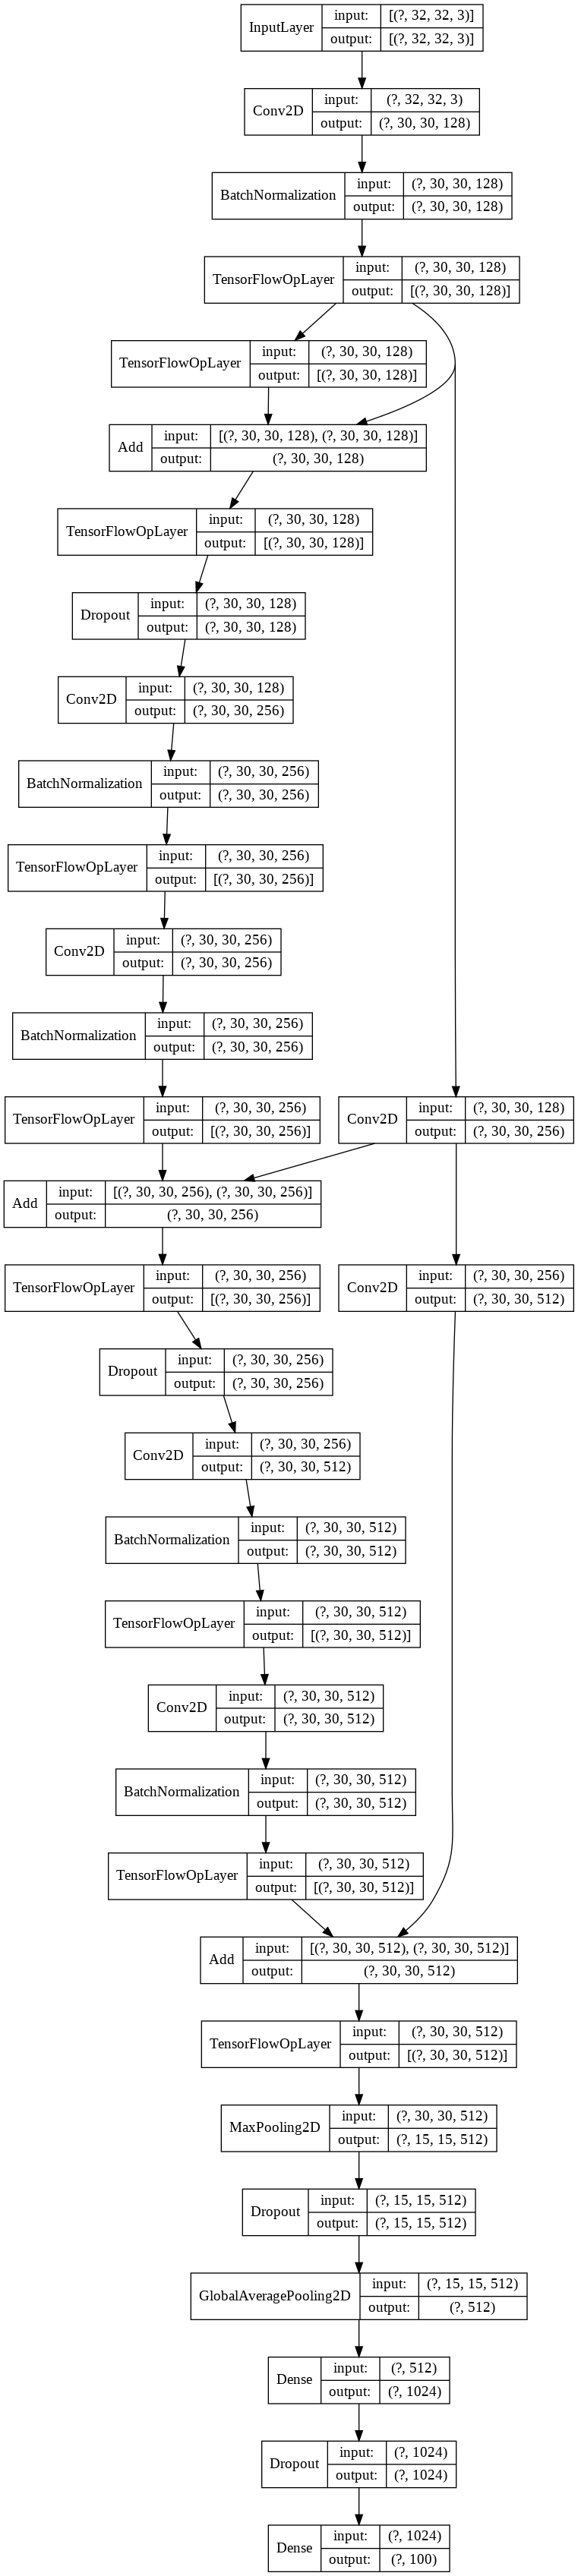

In [16]:
plot_model(model3, to_file='residual.png', show_shapes=True, show_layer_names=False)

In [17]:
model3.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 30, 30, 128)  3456        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 30, 30, 128)  512         conv2d_6[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_Relu (TensorFlowOpL [(None, 30, 30, 128) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
epochs = 50
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("save_model1_at_{epoch}.h5"),
    tf. keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, mode='auto')
]

model3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=["accuracy"]
)

history = model3.fit(
    x_train1,y_train_cat, epochs=epochs, callbacks=callbacks,batch_size=64, validation_data=(x_test1,y_test_cat),
)

## **CNN with concatenation skip connections**

In [19]:
def make_model4(input_shape, num_classes):

    inputs = tf.keras.Input(shape=input_shape)
    
    x =  tf.keras.layers.Conv2D(128,(3, 3),activation='relu',use_bias=False)(inputs)
    x =  tf.keras.layers.BatchNormalization()(x)

    x1 = tf.keras.layers.Conv2D(128,(3, 3),activation='relu',padding='same',use_bias=False)(x)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.Concatenate(axis=-1)([x,x1])
    x1 = tf.keras.layers.Dropout(0.2)(x1)

    x2 = tf.keras.layers.Conv2D(256,(3,3),use_bias=False,activation='relu',padding='same')(x1)
    x2 =  tf.keras.layers.BatchNormalization()(x2)
    x2 = tf.keras.layers.Conv2D(256,(3,3),use_bias=False,activation='relu',padding='same')(x2)
    x2 =  tf.keras.layers.BatchNormalization()(x2)
    x2 = tf.keras.layers.Concatenate(axis=-1)([x,x2])
    x2 = tf.keras.layers.Dropout(0.3)(x2)

    x3 = tf.keras.layers.Conv2D(512,(3,3),use_bias=False,activation='relu',padding='same')(x2)
    x3 =  tf.keras.layers.BatchNormalization()(x3)
    x3 = tf.keras.layers.Conv2D(512,(3,3),use_bias=False,activation='relu',padding='same')(x3)
    x3 =  tf.keras.layers.BatchNormalization()(x3)
    x3 = tf.keras.layers.Concatenate(axis=-1)([x,x3])
    x2 = tf.keras.layers.Dropout(0.3)(x3)

    fusion = tf.keras.layers.Concatenate(axis=-1)([x,x1,x2,x3])
    x3 = tf.keras.layers.MaxPooling2D(2,2)(fusion)
    x3 = tf.keras.layers.Dropout(0.3)(x3)
     
    x3 = tf.keras.layers.GlobalAveragePooling2D()(x3)
       
    x3 = tf.keras.layers.Dense(1024,activation='relu')(x3)
    x3 = tf.keras.layers.Dropout(0.5)(x3)
    
    outputs = tf.keras.layers.Dense(num_classes,activation='softmax')(x3)
    
    return tf.keras.Model(inputs, outputs)

In [20]:
model4 = make_model4((32,32,3), 100)

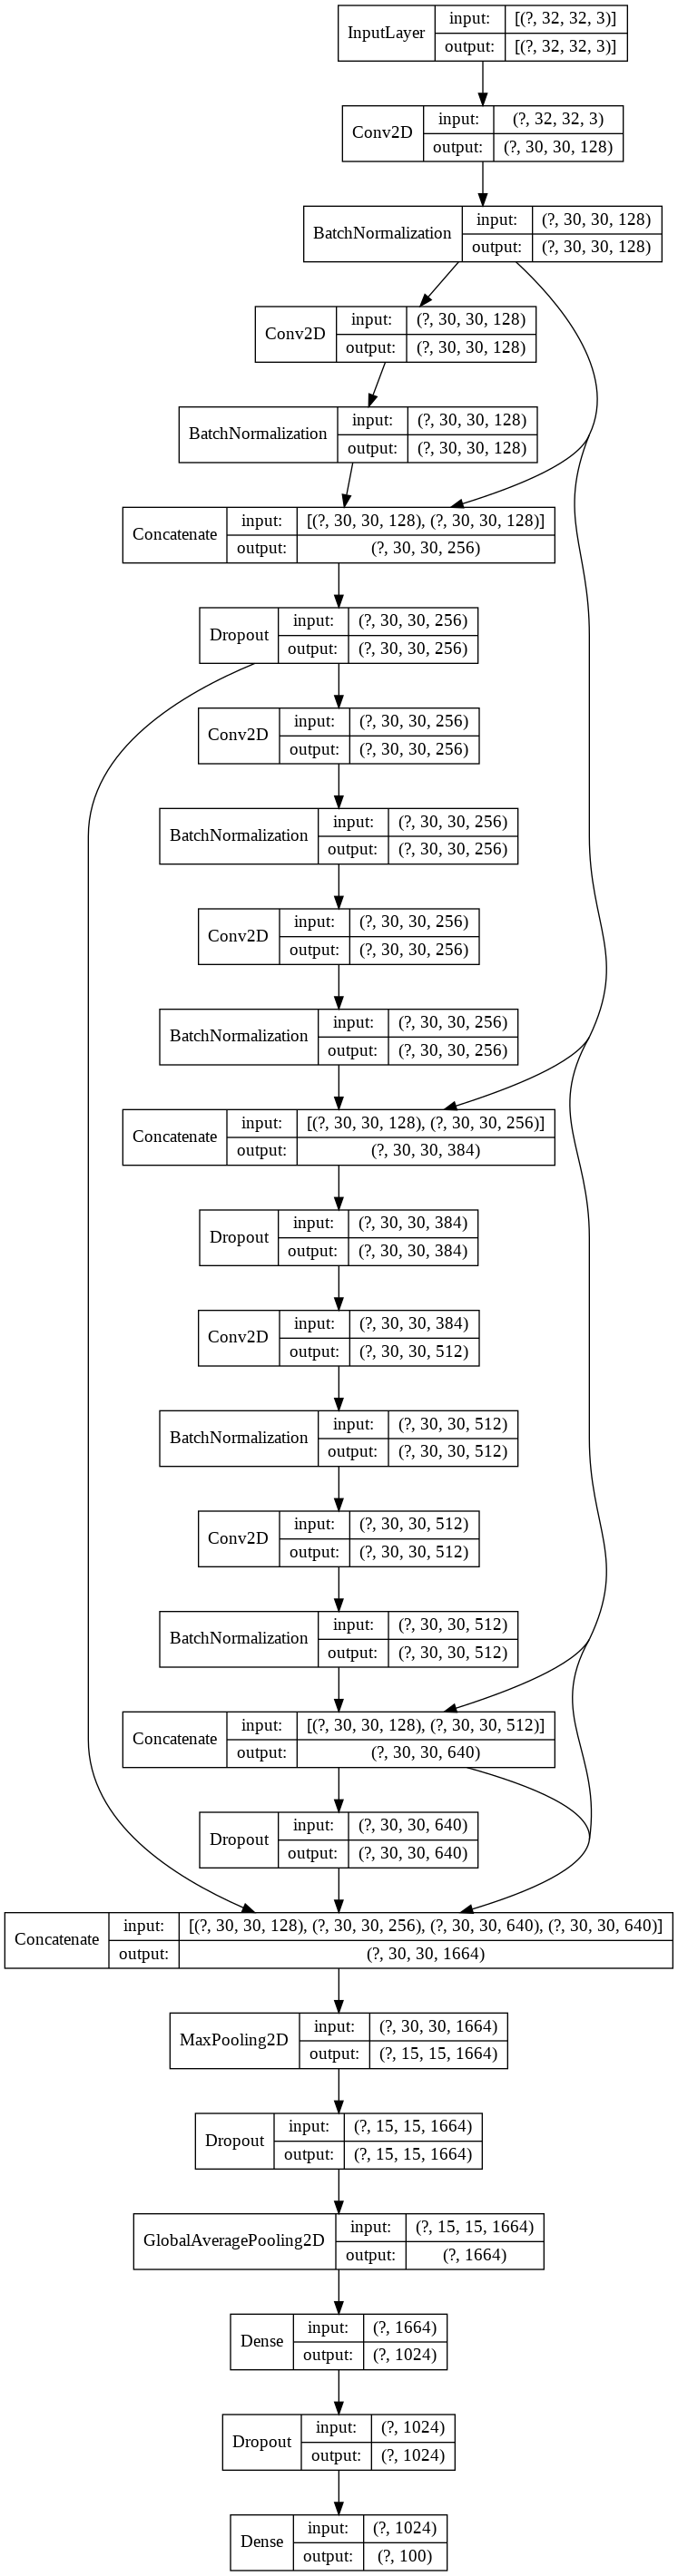

In [21]:
plot_model(model4, to_file='concat.png', show_shapes=True, show_layer_names=False)

In [22]:
model4.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 30, 30, 128)  3456        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 30, 30, 128)  512         conv2d_14[0][0]                  
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 30, 30, 128)  147456      batch_normalization_6[0][0]      
_______________________________________________________________________________________

In [ ]:
epochs = 50
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("save_model1_at_{epoch}.h5"),
    tf. keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, mode='auto')
]

model4.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=["accuracy"]
)

history = model4.fit(
    x_train1,y_train_cat, epochs=epochs, callbacks=callbacks,batch_size=64, validation_data=(x_test1,y_test_cat),
)

## **Plotting**

In [ ]:
#Evaluating Accuracy and Loss of the model
%matplotlib inline
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(epochs) #No. of epochs

#Plot training and test accuracy per epoch
plt.plot(epochs,acc,'b',label='Training Accuracy')
plt.plot(epochs,val_acc,'r',label='Test Accuracy')
plt.legend()
plt.xlabel('Iterations')  
plt.ylabel('Accuracy')  
plt.title("CNN with residual skip connections Accuracy Plot")
plt.figure()

#Plot training and test loss per epoch
plt.plot(epochs,loss,'b',label='Training Loss')
plt.plot(epochs,val_loss,'r',label='Test Loss')
plt.legend()
plt.xlabel('Iterations')  
plt.ylabel('Loss')  
plt.title("CNN with residual skip connections Loss Plot")

plt.show()

In [ ]:
#load the best model
model1.load_weights('/content/save_model1_at_8.h5')

In [ ]:
#predictions
y_pred1 = np.argmax(model1.predict(x_test1),axis=1)

In [ ]:
#Confusion matrix
CM = confusion_matrix(y_test, y_pred1)
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(30, 30))
plt.show()